# Generating Voter Turnout Scores
Anne Bode - Bluebonnet Data Fellow

### 1. Mature Voters
##### Registered for 6+ years prior to election

* **Super Muni Voter** - Voted in prior three off cycle/Muni Elections  
* **Super General/Midterm Voters** - Voted in last two presidential elections + midterm between  
* **Likely Muni Voter** - Voted in at least 1 of prior off cycle/Muni Elections  
* **Likely General/Midterm Voter** - Voted in at least two of past presidental elections + midterm between  
* **Less Likely Voter** - All others 


### 2. Newer Voters
##### Registered for <6 years prior to election
* **Super Muni Young Voter** - Voted in one of past two off cycle/Muni Elections  
* **Super General/Midterm Young Voter** - Voted in last midterm + general  
* **Less Likely Young Voter** - All others  

### 3. VERY New Voters
* **Registered after 2018 Election + voted in 2020**
* **Registered after 2020**

## 1. Prepping the Voter Database

Using our Voter List from VoteBuilder, create a voter database

In [1]:
import pandas as pd
import numpy as np

In [2]:
# import voter universe
df_voters = pd.read_csv('Voter File.csv')
df_voters.info()

<ipython-input-2-52786c09e7a7>:2: DtypeWarning: Columns (19,35,40,53,61,63,86,87,102,113,114,120,121,125,127,128,129,130,131,132,133,134,135,140,141,144,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df_voters = pd.read_csv('Voter File.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Columns: 147 entries, Voter File VANID to SpecialPrimary04 
dtypes: float64(9), int64(6), object(132)
memory usage: 26.9+ MB


In [3]:
# make edits to certain columns
df_voters['DateReg'] = pd.to_datetime(df_voters['DateReg'])
df_voters['Ward'] = df_voters['PrecinctName'].str.split(' ').str[1]

df_voters['Ethnicity (Grouped)'] = np.where(df_voters['CodedRaceName'].str.contains('Black'),'Black',
                                        np.where(df_voters['CodedRaceName'].str.contains('Hispanic'),'Hispanic',
                                                np.where(df_voters['CodedRaceName'].str.contains('Asian'),'Asian',
                                                        np.where(df_voters['CodedRaceName'].str.contains('White'),'White',
                                                        'Other'))))

df_voters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Columns: 149 entries, Voter File VANID to Ethnicity (Grouped)
dtypes: datetime64[ns](1), float64(9), int64(6), object(133)
memory usage: 27.2+ MB


## 2. Prep Data for Logistic Regression Model

Create dummy variables out of categorical variables. Trying to predict likelihood they will vote in the 2021 muni election. We will regress 2009, 2013, 2017 vote outcome on applicable voters & features.  

Note: this model will only be helpful for voting behavior of people who have been registered for 6 years before election; will need to run a second model to predict newer voters' behaviors.

In [4]:
# include only the variables we care about for our logistic regression
df_reg = df_voters[['Voter File VANID',
                    'Sex',
                    'Age',
                    'DateReg',
                    'Party',
                    'CodedRaceName',
                    'General20',
                    'General18',
                    'General16',
                    'General14',
                    'General12',
                    'General10',
                    'General08',
                    'General06',
                    'General04',
                    'Municipal19',
                    'Municipal17',
                    'Municipal15',
                    'Municipal13',
                    'Municipal11',
                    'Municipal09',
                    'Municipal07',
                    'Municipal05',
                    'Municipal03'
                    ]].copy(deep=True)

# create dummy variables
df_reg['Woman?'] = np.where(df_reg['Sex']=='F',1,0)

df_reg['AgeMuni17'] = df_reg['Age']-4
df_reg['AgeMuni13'] = df_reg['Age']-8
df_reg['AgeMuni09'] = df_reg['Age']-12

df_reg['Democrat/Green?'] = np.where(df_reg['Party']=='D',1,np.where(df_reg['Party']=='G',1,0))
    
df_reg['Black'] = np.where(df_reg['CodedRaceName'].str.contains('Black'),1,0)
df_reg['Hispanic'] = np.where(df_reg['CodedRaceName'].str.contains('Hispanic'),1,0)
df_reg['Asian'] = np.where(df_reg['CodedRaceName'].str.contains('Asian'),1,0)
df_reg['White'] = np.where(df_reg['CodedRaceName'].str.contains('White'),1,0)

df_reg = df_reg.replace(to_replace=['Y','NaN'],value=[1,0])
df_reg = df_reg.fillna(0)

df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Voter File VANID  23967 non-null  int64         
 1   Sex               23967 non-null  object        
 2   Age               23967 non-null  int64         
 3   DateReg           23967 non-null  datetime64[ns]
 4   Party             23967 non-null  object        
 5   CodedRaceName     23967 non-null  object        
 6   General20         23967 non-null  float64       
 7   General18         23967 non-null  float64       
 8   General16         23967 non-null  float64       
 9   General14         23967 non-null  float64       
 10  General12         23967 non-null  float64       
 11  General10         23967 non-null  float64       
 12  General08         23967 non-null  float64       
 13  General06         23967 non-null  float64       
 14  General04         2396

In [5]:
# create dataframe of just the relevant voters in 2017 muni election (registered for 6 years prior to election) and rename columns
# that way we can create the same dataframe for 2013 and 2009 and merge them to go off of more datapoints

df_reg_2017 = df_reg[['Voter File VANID',
                      'Woman?',
                      'AgeMuni17',
                      'DateReg',
                      'Democrat/Green?',
                      'Black',
                      'Hispanic',
                      'Asian',
                      'White',
                      'General16',
                      'General14',
                      'General12',
                      'Municipal17',
                      'Municipal15',
                      'Municipal13',
                      'Municipal11'
                     ]].copy()

df_reg_2017 = df_reg_2017[df_reg_2017['DateReg']<='2011/11/08']
df_reg_2017.reset_index(inplace=True,drop=True)
df_reg_2017['Year'] = '2017'

df_reg_2017.rename(columns={'AgeMuni17':'AgeMuni',
                            'General16':'General-1',
                            'General14':'Midterm-1',
                            'General12':'General-2',
                            'Municipal17':'MuniRace',
                            'Municipal15':'MuniRace-1',
                            'Municipal13':'MuniRace-2',
                            'Municipal11':'MuniRace-3'},inplace=True)

df_reg_2017['AgeInt'] = df_reg_2017['AgeMuni'] // 10

df_reg_2017['20s'] = np.where(df_reg_2017['AgeInt']==2,1,0)
df_reg_2017['30s'] = np.where(df_reg_2017['AgeInt']==3,1,0)
df_reg_2017['40s'] = np.where(df_reg_2017['AgeInt']==4,1,0)
df_reg_2017['50s'] = np.where(df_reg_2017['AgeInt']==5,1,0)
df_reg_2017['60s'] = np.where(df_reg_2017['AgeInt']==6,1,0)
df_reg_2017['70s'] = np.where(df_reg_2017['AgeInt']==7,1,0)
df_reg_2017['80s'] = np.where(df_reg_2017['AgeInt']==8,1,0)

df_reg_2017['Gen Record'] = df_reg_2017['General-1'] + df_reg_2017['Midterm-1'] + df_reg_2017['General-2']
df_reg_2017['Super Gen Voter'] = np.where(df_reg_2017['Gen Record']==3,1,0)
df_reg_2017['Likely Gen Voter'] = np.where(df_reg_2017['Gen Record']==2,1,0)

df_reg_2017['Muni Record'] = df_reg_2017['MuniRace-1'] + df_reg_2017['MuniRace-2'] + df_reg_2017['MuniRace-3']
df_reg_2017['Super Muni Voter'] = np.where(df_reg_2017['Muni Record']==3,1,0)
df_reg_2017['Likely Muni Voter'] = np.where(df_reg_2017['Muni Record']==0,0,
                                           np.where(df_reg_2017['Muni Record']<3,1,0))

df_reg_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13255 entries, 0 to 13254
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Voter File VANID   13255 non-null  int64         
 1   Woman?             13255 non-null  int32         
 2   AgeMuni            13255 non-null  int64         
 3   DateReg            13255 non-null  datetime64[ns]
 4   Democrat/Green?    13255 non-null  int32         
 5   Black              13255 non-null  int32         
 6   Hispanic           13255 non-null  int32         
 7   Asian              13255 non-null  int32         
 8   White              13255 non-null  int32         
 9   General-1          13255 non-null  float64       
 10  Midterm-1          13255 non-null  float64       
 11  General-2          13255 non-null  float64       
 12  MuniRace           13255 non-null  float64       
 13  MuniRace-1         13255 non-null  float64       
 14  MuniRa

In [6]:
# create dataframe of just the relevant voters in 2013 muni election (registered for 6 years prior to election) and rename columns

df_reg_2013 = df_reg[['Voter File VANID',
                      'Woman?',
                      'AgeMuni13',
                      'DateReg',
                      'Democrat/Green?',
                      'Black',
                      'Hispanic',
                      'Asian',
                      'White',
                      'General12',
                      'General10',
                      'General08',
                      'Municipal13',
                      'Municipal11',
                      'Municipal09',
                      'Municipal07'
                     ]].copy()

df_reg_2013 = df_reg_2013[df_reg_2013['DateReg']<='2007/11/06']
df_reg_2013.reset_index(inplace=True,drop=True)
df_reg_2013['Year'] = '2013'

df_reg_2013.rename(columns={'AgeMuni13':'AgeMuni',
                            'General12':'General-1',
                            'General10':'Midterm-1',
                            'General08':'General-2',
                            'Municipal13':'MuniRace',
                            'Municipal11':'MuniRace-1',
                            'Municipal09':'MuniRace-2',
                            'Municipal07':'MuniRace-3'},inplace=True)

df_reg_2013['AgeInt'] = df_reg_2013['AgeMuni'] // 10

df_reg_2013['20s'] = np.where(df_reg_2013['AgeInt']==2,1,0)
df_reg_2013['30s'] = np.where(df_reg_2013['AgeInt']==3,1,0)
df_reg_2013['40s'] = np.where(df_reg_2013['AgeInt']==4,1,0)
df_reg_2013['50s'] = np.where(df_reg_2013['AgeInt']==5,1,0)
df_reg_2013['60s'] = np.where(df_reg_2013['AgeInt']==6,1,0)
df_reg_2013['70s'] = np.where(df_reg_2013['AgeInt']==7,1,0)
df_reg_2013['80s'] = np.where(df_reg_2013['AgeInt']==8,1,0)

df_reg_2013['Gen Record'] = df_reg_2013['General-1'] + df_reg_2013['Midterm-1'] + df_reg_2013['General-2']
df_reg_2013['Super Gen Voter'] = np.where(df_reg_2013['Gen Record']==3,1,0)
df_reg_2013['Likely Gen Voter'] = np.where(df_reg_2013['Gen Record']==2,1,0)

df_reg_2013['Muni Record'] = df_reg_2013['MuniRace-1'] + df_reg_2013['MuniRace-2'] + df_reg_2013['MuniRace-3']
df_reg_2013['Super Muni Voter'] = np.where(df_reg_2013['Muni Record']==3,1,0)
df_reg_2013['Likely Muni Voter'] = np.where(df_reg_2013['Muni Record']==0,0,
                                           np.where(df_reg_2013['Muni Record']<3,1,0))

df_reg_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10099 entries, 0 to 10098
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Voter File VANID   10099 non-null  int64         
 1   Woman?             10099 non-null  int32         
 2   AgeMuni            10099 non-null  int64         
 3   DateReg            10099 non-null  datetime64[ns]
 4   Democrat/Green?    10099 non-null  int32         
 5   Black              10099 non-null  int32         
 6   Hispanic           10099 non-null  int32         
 7   Asian              10099 non-null  int32         
 8   White              10099 non-null  int32         
 9   General-1          10099 non-null  float64       
 10  Midterm-1          10099 non-null  float64       
 11  General-2          10099 non-null  float64       
 12  MuniRace           10099 non-null  float64       
 13  MuniRace-1         10099 non-null  float64       
 14  MuniRa

In [7]:
# create dataframe of just the relevant voters in 2009 muni election (registered for 6 years prior to election) and rename columns

df_reg_2009 = df_reg[['Voter File VANID',
                      'Woman?',
                      'AgeMuni09',
                      'DateReg',
                      'Democrat/Green?',
                      'Black',
                      'Hispanic',
                      'Asian',
                      'White',
                      'General08',
                      'General06',
                      'General04',
                      'Municipal09',
                      'Municipal07',
                      'Municipal05',
                      'Municipal03'
                     ]].copy()

df_reg_2009 = df_reg_2009[df_reg_2009['DateReg']<='2003/11/04']
df_reg_2009.reset_index(inplace=True,drop=True)
df_reg_2009['Year'] = '2009'

df_reg_2009.rename(columns={'AgeMuni09':'AgeMuni',
                            'General08':'General-1',
                            'General06':'Midterm-1',
                            'General04':'General-2',
                            'Municipal09':'MuniRace',
                            'Municipal07':'MuniRace-1',
                            'Municipal05':'MuniRace-2',
                            'Municipal03':'MuniRace-3'},inplace=True)

df_reg_2009['AgeInt'] = df_reg_2009['AgeMuni'] // 10

df_reg_2009['20s'] = np.where(df_reg_2009['AgeInt']==2,1,0)
df_reg_2009['30s'] = np.where(df_reg_2009['AgeInt']==3,1,0)
df_reg_2009['40s'] = np.where(df_reg_2009['AgeInt']==4,1,0)
df_reg_2009['50s'] = np.where(df_reg_2009['AgeInt']==5,1,0)
df_reg_2009['60s'] = np.where(df_reg_2009['AgeInt']==6,1,0)
df_reg_2009['70s'] = np.where(df_reg_2009['AgeInt']==7,1,0)
df_reg_2009['80s'] = np.where(df_reg_2009['AgeInt']==8,1,0)

df_reg_2009['Gen Record'] = df_reg_2009['General-1'] + df_reg_2009['Midterm-1'] + df_reg_2009['General-2']
df_reg_2009['Super Gen Voter'] = np.where(df_reg_2009['Gen Record']==3,1,0)
df_reg_2009['Likely Gen Voter'] = np.where(df_reg_2009['Gen Record']==2,1,0)

df_reg_2009['Muni Record'] = df_reg_2009['MuniRace-1'] + df_reg_2009['MuniRace-2'] + df_reg_2009['MuniRace-3']
df_reg_2009['Super Muni Voter'] = np.where(df_reg_2009['Muni Record']==3,1,0)
df_reg_2009['Likely Muni Voter'] = np.where(df_reg_2009['Muni Record']==0,0,
                                           np.where(df_reg_2009['Muni Record']<3,1,0))

df_reg_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7260 entries, 0 to 7259
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Voter File VANID   7260 non-null   int64         
 1   Woman?             7260 non-null   int32         
 2   AgeMuni            7260 non-null   int64         
 3   DateReg            7260 non-null   datetime64[ns]
 4   Democrat/Green?    7260 non-null   int32         
 5   Black              7260 non-null   int32         
 6   Hispanic           7260 non-null   int32         
 7   Asian              7260 non-null   int32         
 8   White              7260 non-null   int32         
 9   General-1          7260 non-null   float64       
 10  Midterm-1          7260 non-null   float64       
 11  General-2          7260 non-null   float64       
 12  MuniRace           7260 non-null   float64       
 13  MuniRace-1         7260 non-null   float64       
 14  MuniRace

In [8]:
# merge data frames

df_reg_final = df_reg_2017.append(df_reg_2013, ignore_index=True)
df_reg_final = df_reg_final.append(df_reg_2009, ignore_index=True)
df_reg_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30614 entries, 0 to 30613
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Voter File VANID   30614 non-null  int64         
 1   Woman?             30614 non-null  int32         
 2   AgeMuni            30614 non-null  int64         
 3   DateReg            30614 non-null  datetime64[ns]
 4   Democrat/Green?    30614 non-null  int32         
 5   Black              30614 non-null  int32         
 6   Hispanic           30614 non-null  int32         
 7   Asian              30614 non-null  int32         
 8   White              30614 non-null  int32         
 9   General-1          30614 non-null  float64       
 10  Midterm-1          30614 non-null  float64       
 11  General-2          30614 non-null  float64       
 12  MuniRace           30614 non-null  float64       
 13  MuniRace-1         30614 non-null  float64       
 14  MuniRa

<ipython-input-8-d9d9abbbe890>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_reg_final = df_reg_2017.append(df_reg_2013, ignore_index=True)
<ipython-input-8-d9d9abbbe890>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_reg_final = df_reg_final.append(df_reg_2009, ignore_index=True)


In [9]:
# create dataframe of just the relevant voters in 2021 muni election (registered for 6 years prior to election) and rename columns

df_reg_2021 = df_reg[['Voter File VANID',
                      'Woman?',
                      'Age',
                      'DateReg',
                      'Democrat/Green?',
                      'Black',
                      'Hispanic',
                      'Asian',
                      'White',
                      'General20', #gen-1
                      'General18', #mid-1
                      'General16', #gen-2
                      'Municipal19', #muni-1
                      'Municipal17', #muni-2 (MAYORAL)
                      'Municipal15' #muni-3
                     ]].copy()

df_reg_2021 = df_reg_2021[df_reg_2021['DateReg']<='2015/11/03']
df_reg_2021.reset_index(inplace=True,drop=True)
df_reg_2021['Year'] = '2021'

df_reg_2021.rename(columns={'Age':'AgeMuni',
                            'General20':'General-1',
                            'General18':'Midterm-1',
                            'General16':'General-2',
                            'Municipal19':'MuniRace-1',
                            'Municipal17':'MuniRace-2',
                            'Municipal15':'MuniRace-3'},inplace=True)

df_reg_2021['AgeInt'] = df_reg_2021['AgeMuni'] // 10

df_reg_2021['20s'] = np.where(df_reg_2021['AgeInt']==2,1,0)
df_reg_2021['30s'] = np.where(df_reg_2021['AgeInt']==3,1,0)
df_reg_2021['40s'] = np.where(df_reg_2021['AgeInt']==4,1,0)
df_reg_2021['50s'] = np.where(df_reg_2021['AgeInt']==5,1,0)
df_reg_2021['60s'] = np.where(df_reg_2021['AgeInt']==6,1,0)
df_reg_2021['70s'] = np.where(df_reg_2021['AgeInt']==7,1,0)
df_reg_2021['80s'] = np.where(df_reg_2021['AgeInt']==8,1,0)

df_reg_2021['Gen Record'] = df_reg_2021['General-1'] + df_reg_2021['Midterm-1'] + df_reg_2021['General-2']
df_reg_2021['Super Gen Voter'] = np.where(df_reg_2021['Gen Record']==3,1,0)
df_reg_2021['Likely Gen Voter'] = np.where(df_reg_2021['Gen Record']==2,1,0)

df_reg_2021['Muni Record'] = df_reg_2021['MuniRace-1'] + df_reg_2021['MuniRace-2'] + df_reg_2021['MuniRace-3']
df_reg_2021['Super Muni Voter'] = np.where(df_reg_2021['Muni Record']==3,1,0)
df_reg_2021['Likely Muni Voter'] = np.where(df_reg_2021['Muni Record']==0,0,np.where(df_reg_2021['Muni Record']<3,1,0))
    
df_reg_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17071 entries, 0 to 17070
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Voter File VANID   17071 non-null  int64         
 1   Woman?             17071 non-null  int32         
 2   AgeMuni            17071 non-null  int64         
 3   DateReg            17071 non-null  datetime64[ns]
 4   Democrat/Green?    17071 non-null  int32         
 5   Black              17071 non-null  int32         
 6   Hispanic           17071 non-null  int32         
 7   Asian              17071 non-null  int32         
 8   White              17071 non-null  int32         
 9   General-1          17071 non-null  float64       
 10  Midterm-1          17071 non-null  float64       
 11  General-2          17071 non-null  float64       
 12  MuniRace-1         17071 non-null  float64       
 13  MuniRace-2         17071 non-null  float64       
 14  MuniRa

## 3. Create Logistic Regression Model

In [10]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

C:\Users\abode\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\abode\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [11]:
y = df_reg_final['MuniRace']
x = df_reg_final[['Voter File VANID',
                  #'Woman?',
                  #'Democrat/Green?',
                  #'Black',
                  #'Hispanic',
                  #'Asian',
                  #'White',
                  '20s',
                  '30s',
                  '40s',
                  '50s',
                  '60s',
                  '70s',
                  '80s',
                  'Super Gen Voter',
                  'Likely Gen Voter',
                  'Super Muni Voter',
                  'Likely Muni Voter'
                 ]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [12]:
logit_model = sm.Logit(y_train,x_train.drop(columns=['Voter File VANID'])).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.494263
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               MuniRace   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22949
Method:                           MLE   Df Model:                           10
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                  0.2824
Time:                        08:49:20   Log-Likelihood:                -11348.
converged:                       True   LL-Null:                       -15814.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
20s                  -2.7156      0.068    -40.136      0.000      -2.848      -2.583
30s     

In [13]:
yhat = logit_model.predict(x_test.drop(columns=['Voter File VANID']))
prediction = list(map(round, yhat))

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
  
# confusion matrix
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
score = accuracy_score(y_test, prediction)
print(f'\n Score: {score*100:.2f}%')

Confusion Matrix : 
 [[3421  771]
 [ 892 2570]]

 Score: 78.27%


In [15]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Overall Accuracy with 50% Threshold: {score*100:.2f}%'
plt.title(all_sample_title, size = 15);

In [16]:
print(f'True Positive Rate (Sensitivity): {cm[1,1]/cm[1].sum()*100:.2f}%')
print(f'False Positive Rate: {cm[0,1]/cm[0].sum()*100:.2f}%')
print(f'Accuracy Within Target Group: {cm[1,1]/cm[:,1].sum()*100:.2f}%')
print(f'Voters Targeted: {sum(prediction):,.0f}')

True Positive Rate (Sensitivity): 74.23%
False Positive Rate: 18.39%
Accuracy Within Target Group: 76.92%
Voters Targeted: 3,341


In [17]:
prediction_2 = list(yhat)

for i in range(len(prediction_2)):
    if prediction_2[i] >= 0.75:
        prediction_2[i] = 1
    else:
        prediction_2[i] = 0

# confusion matrix
cm = confusion_matrix(y_test, prediction_2) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
score = accuracy_score(y_test, prediction_2)
print(f'\n Score: {score*100:.2f}%')

Confusion Matrix : 
 [[4099   93]
 [2535  927]]

 Score: 65.67%


In [18]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Overall Accuracy with 75% Threshold: {score*100:.2f}%'
plt.title(all_sample_title, size = 15);

In [19]:
print(f'Sensitivity (True Positive Rate): {cm[1,1]/cm[1].sum()*100:.2f}%')
print(f'False Positive Rate: {cm[0,1]/cm[0].sum()*100:.2f}%')
print(f'Accuracy Within Target Group: {cm[1,1]/cm[:,1].sum()*100:.2f}%')
print(f'Voters Targeted: {sum(prediction_2):,.0f}')

Sensitivity (True Positive Rate): 26.78%
False Positive Rate: 2.22%
Accuracy Within Target Group: 90.88%
Voters Targeted: 1,020


## 4. Use Logistic Regression to Assign Turnout Scores for 2021 Election

In [20]:
# refit model on both train and test set
logit_model = sm.Logit(y, x.drop(columns=['Voter File VANID'])).fit()

Optimization terminated successfully.
         Current function value: 0.491003
         Iterations 6


In [21]:
x_2021 = df_reg_2021[[#'Woman?',
                      #'Democrat/Green?',
                      #'Black',
                      #'Hispanic',
                      #'Asian',
                      #'White',
                      '20s',
                      '30s',
                      '40s',
                      '50s',
                      '60s',
                      '70s',
                      '80s',
                      'Super Gen Voter',
                      'Likely Gen Voter',
                      'Super Muni Voter',
                      'Likely Muni Voter'
                    ]]

yhat_2021 = logit_model.predict(x_2021)
df_reg_2021['TurnoutScore'] = yhat_2021
df_reg_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17071 entries, 0 to 17070
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Voter File VANID   17071 non-null  int64         
 1   Woman?             17071 non-null  int32         
 2   AgeMuni            17071 non-null  int64         
 3   DateReg            17071 non-null  datetime64[ns]
 4   Democrat/Green?    17071 non-null  int32         
 5   Black              17071 non-null  int32         
 6   Hispanic           17071 non-null  int32         
 7   Asian              17071 non-null  int32         
 8   White              17071 non-null  int32         
 9   General-1          17071 non-null  float64       
 10  Midterm-1          17071 non-null  float64       
 11  General-2          17071 non-null  float64       
 12  MuniRace-1         17071 non-null  float64       
 13  MuniRace-2         17071 non-null  float64       
 14  MuniRa

In [22]:
df_final = pd.merge(df_voters, df_reg_2021[['Voter File VANID','TurnoutScore']],on='Voter File VANID',how='left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23967 entries, 0 to 23966
Columns: 150 entries, Voter File VANID to TurnoutScore
dtypes: datetime64[ns](1), float64(10), int64(6), object(133)
memory usage: 27.6+ MB


## 5. Visualize Likely Voter Stats

In [23]:
turnout_threshold = 0.75
df_likely_voters = df_final[df_final['TurnoutScore']>=0.75]
df_likely_voters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 5 to 23941
Columns: 150 entries, Voter File VANID to TurnoutScore
dtypes: datetime64[ns](1), float64(10), int64(6), object(133)
memory usage: 2.0+ MB


In [24]:
len(df_likely_voters)

1758

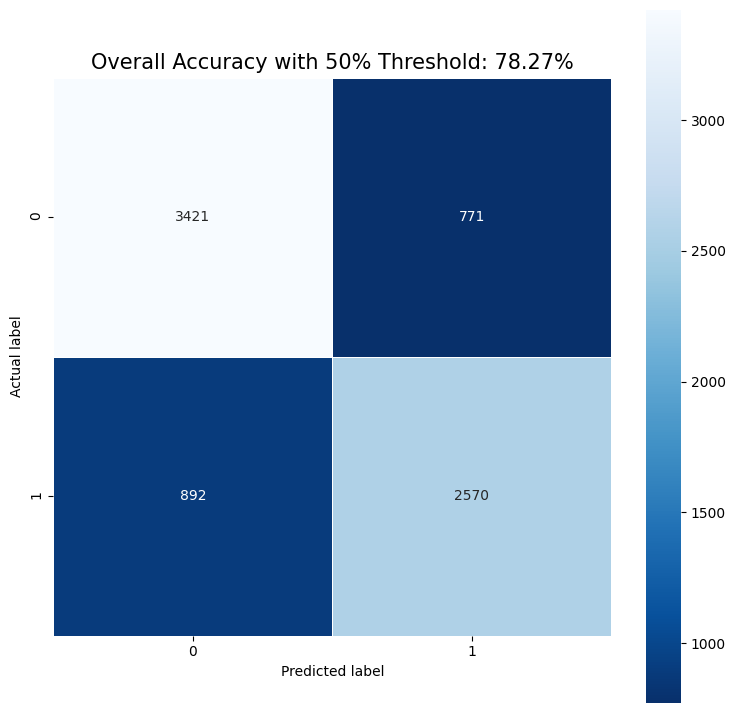

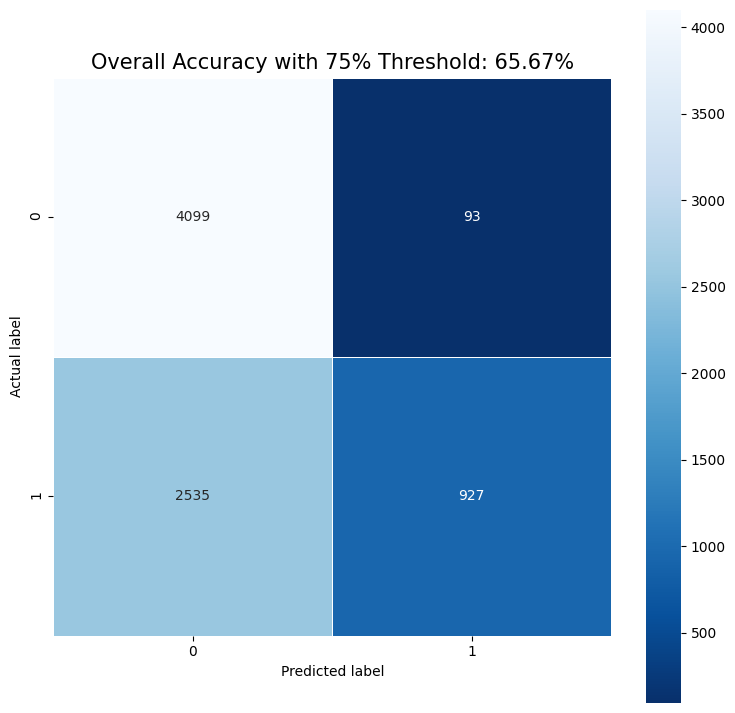

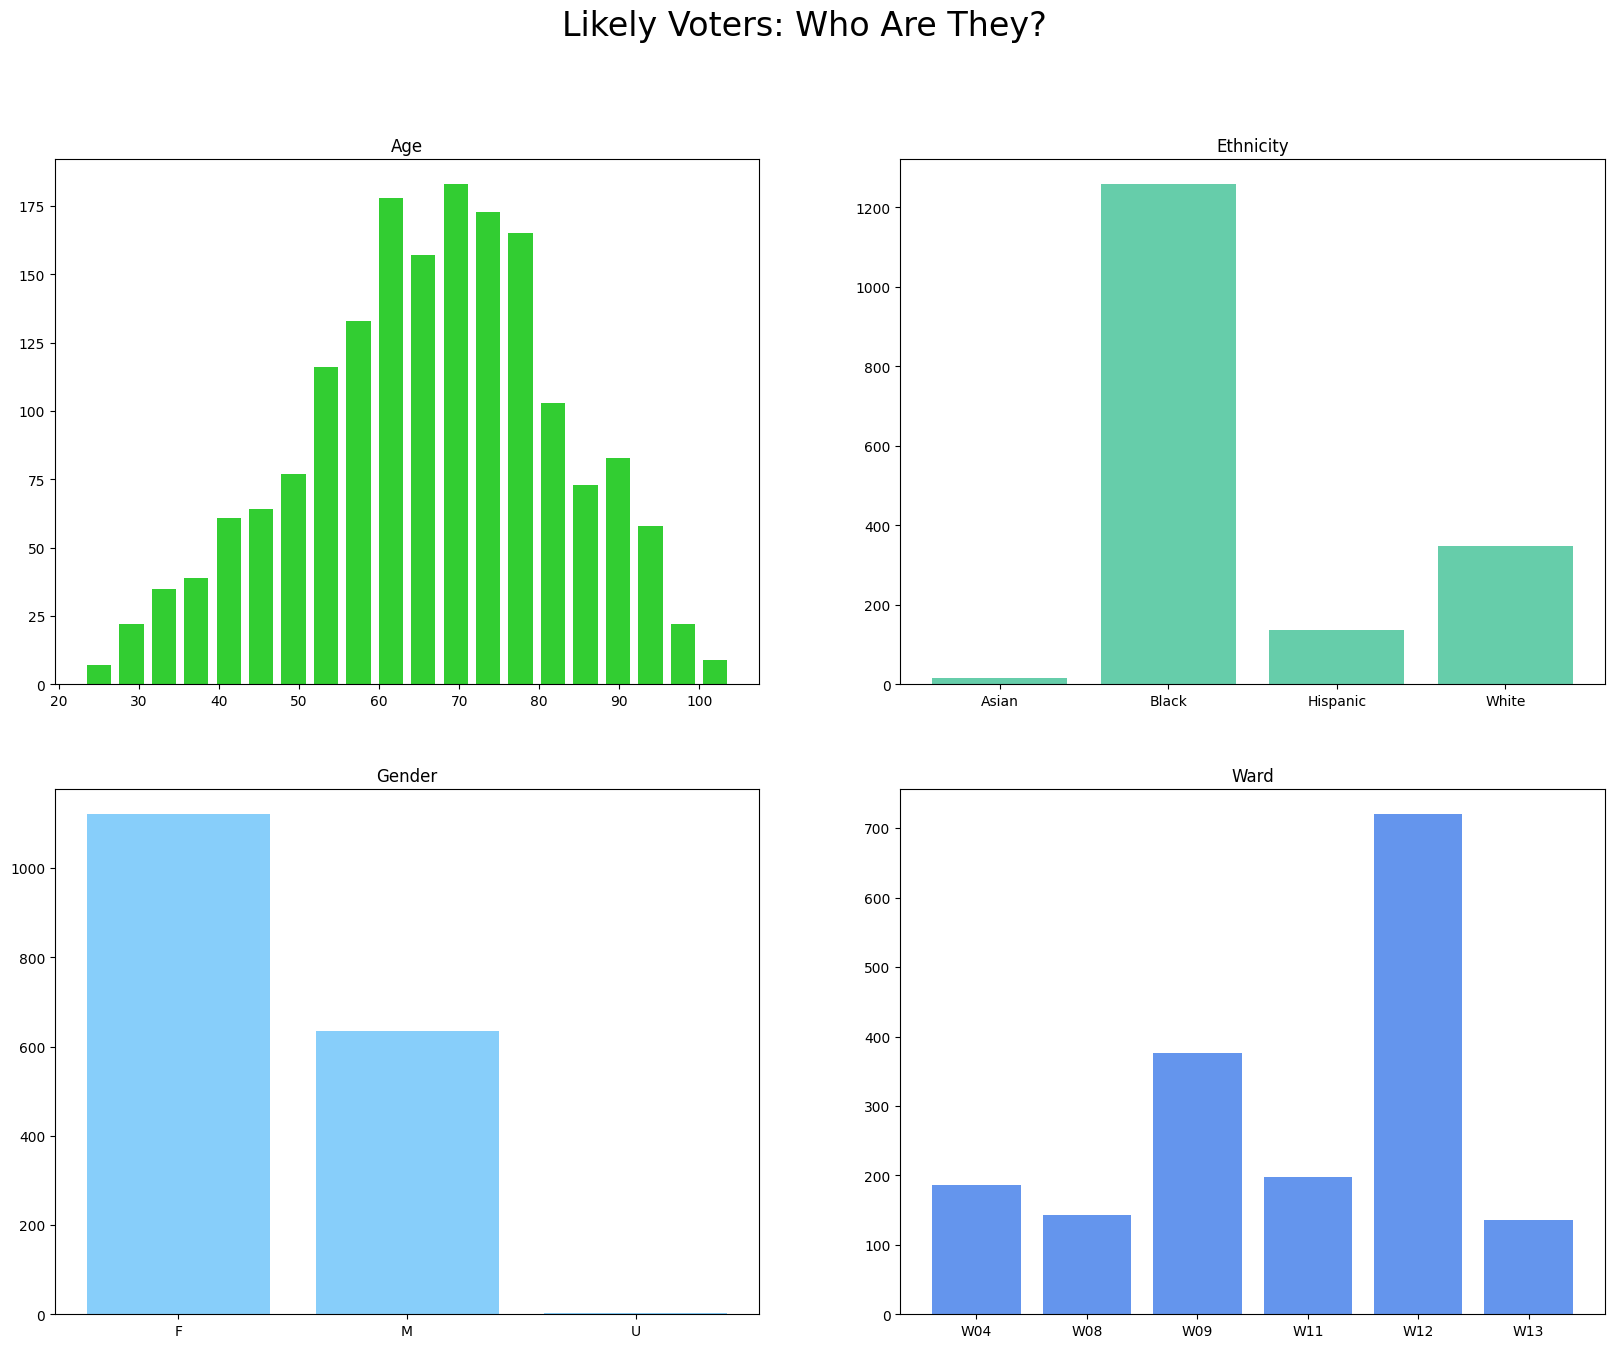

In [25]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,15))
fig.suptitle('Likely Voters: Who Are They?',size=24)

axs = axs.ravel()

axs[0].hist(df_likely_voters['Age'], bins=20, rwidth=0.75, color='limegreen')
axs[0].set_title('Age')

labels, counts = np.unique(df_likely_voters['Ethnicity (Grouped)'], return_counts=True)
axs[1].bar(labels, counts, align='center',color='mediumaquamarine')
axs[1].set_title('Ethnicity')

labels, counts = np.unique(df_likely_voters['Sex'], return_counts=True)
axs[2].bar(labels, counts, align='center',color='lightskyblue')
axs[2].set_title('Gender')

labels, counts = np.unique(df_likely_voters['Ward'], return_counts=True)
axs[3].bar(labels, counts, align='center',color='cornflowerblue')
axs[3].set_title('Ward')

plt.show()